# Importamos librerias

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Analisis exploratorio de los datos

cargar los datos en los respectivos DataFrames

In [2]:
df_visits = pd.read_csv('./visits_log_us.csv')
df_orders = pd.read_csv('./orders_log_us.csv')
df_costs = pd.read_csv('./costs_us.csv')

## Se modifica el formato de las columnas necesarias

In [3]:
df_visits.info()

df_orders.info()

df_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 

Se cambian los tipos de datos de las columnas que contienen fecha a datetime para poder trabajar correctamente con la informacion

In [4]:
df_visits['End Ts'] = pd.to_datetime(df_visits['End Ts'])
df_visits['Start Ts'] = pd.to_datetime(df_visits['Start Ts'])

df_orders['Buy Ts'] = pd.to_datetime(df_orders['Buy Ts'])

df_costs['dt'] = pd.to_datetime(df_costs['dt'])

Con las columnas teniendo el tipo de dato que deberian, al no tener valores nulos y despues de hecharle un vista a las primeras filas de cada DataFrame se procede a analizar la informacion de los DataFrames.

Es importante informar que los datos estan desde 2017-06-01 hasta 2018-05-31, es algo a tener en cuenta dado que inicialmente se menciona que se tienen datos desde 2017-01 hasta 2018-12, es posible que se tuviese una perdida de datos en procesos previos, o que la toma de datos fue menor a la que inicialmente se penso

# Analisis de las visitas

Al DataFrame de visitas se agregan las columnas de fecha necesarias para un analisis mas profundo

In [5]:
df_visits['year'] = df_visits['Start Ts'].dt.year
df_visits['month'] = df_visits['Start Ts'].dt.month
df_visits['week'] = df_visits['Start Ts'].dt.isocalendar().week
df_visits['day'] = df_visits['Start Ts'].dt.day

## ¿Cuántas personas lo usan cada día, semana y mes?

Se cuenta el numero unico de usuarios que iniciaron sesion

In [6]:
users_per_day = df_visits.groupby(['year','month','day']).agg({'Uid':'nunique'})
users_per_week = df_visits.groupby(['year','week']).agg({'Uid':'nunique'})
users_per_month = df_visits.groupby(['year','month']).agg({'Uid':'nunique'})

Se muestran las graficas de  

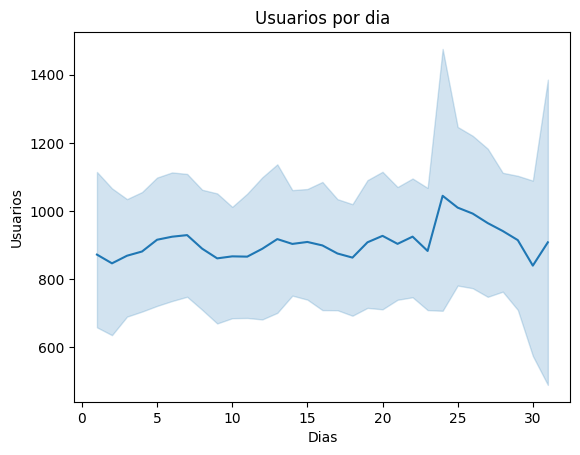

En promedio la pagina fue visitada al día por 908 personas


In [7]:
ax = sns.lineplot(x='day', y='Uid',data=users_per_day)
plt.title('Usuarios por dia')
ax.set(xlabel='Dias', ylabel='Usuarios')
plt.show()

print(f"En promedio la pagina fue visitada al día por {round((users_per_day.mean()).iloc[0])} personas")

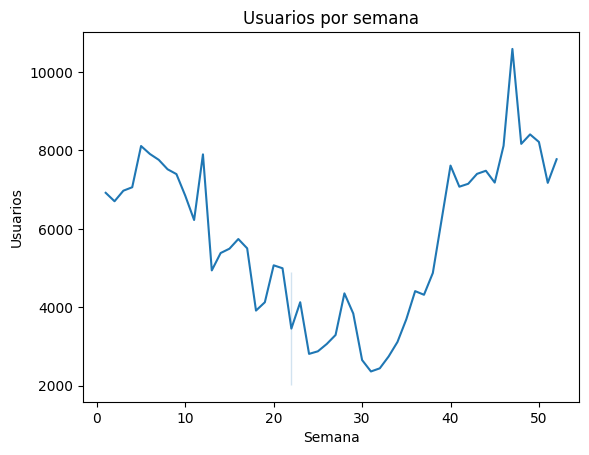

En promedio la pagina fue visitada semanalmente por 5716 personas


In [8]:
ax = sns.lineplot(x='week', y='Uid',data=users_per_week)
plt.title('Usuarios por semana')
ax.set(xlabel='Semana', ylabel='Usuarios')
plt.show()

print(f"En promedio la pagina fue visitada semanalmente por {round((users_per_week.mean()).iloc[0])} personas")

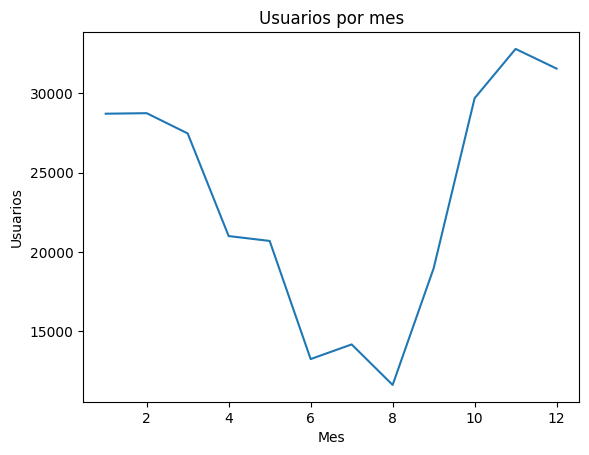

En promedio la pagina fue visitada al mes por 23228 personas


In [9]:
ax = sns.lineplot(x='month', y='Uid',data=users_per_month)
plt.title('Usuarios por mes')
ax.set(xlabel='Mes', ylabel='Usuarios')
plt.show()

print(f"En promedio la pagina fue visitada al mes por {round((users_per_month.mean()).iloc[0])} personas")

## ¿Cuántas sesiones hay por día? (Un usuario puede tener más de una sesión).

In [10]:
sessions_per_day = df_visits.groupby(['year','month','day']).agg({'Uid':'count'})

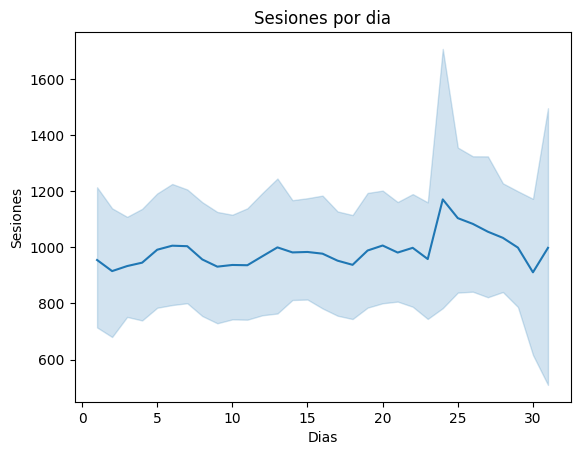

En promedio hay 987 sesiones por dia


In [11]:
ax = sns.lineplot(x='day', y='Uid',data=sessions_per_day)
plt.title('Sesiones por dia')
ax.set(xlabel='Dias', ylabel='Sesiones')
plt.show()

print(f"En promedio hay {round(sessions_per_day.mean().iloc[0])} sesiones por dia")

Teniendo en cuenta que la cantidad de usuarios unicos que visitan la pagina al dia es un promedio de 908, tenemos usuarios que se estan conectando en mas de una ocacion.

## ¿Cuál es la duración de cada sesión?

In [12]:
df_visits['duration'] = (df_visits['End Ts'] - df_visits['Start Ts']).dt.total_seconds()

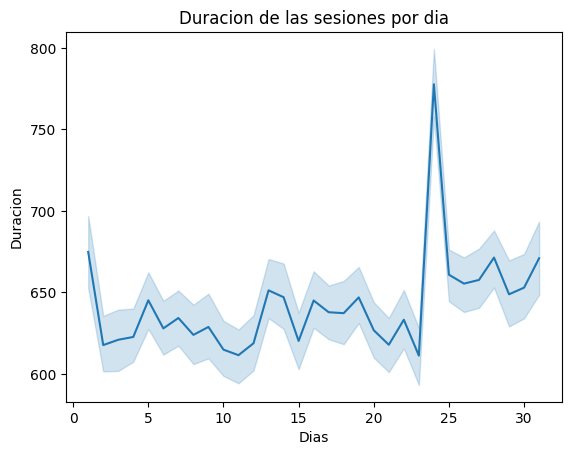

Cada sesion dura en promedio 643 segundos


In [13]:
ax = sns.lineplot(x='day', y='duration',data=df_visits)
plt.title('Duracion de las sesiones por dia')
ax.set(xlabel='Dias', ylabel='Duracion')
plt.show()

print(f"Cada sesion dura en promedio {round(df_visits['duration'].mean())} segundos")

## ¿Con qué frecuencia los usuarios regresan?

Los usuarios regresan a visitar la pagina en promedio cada 8 dias


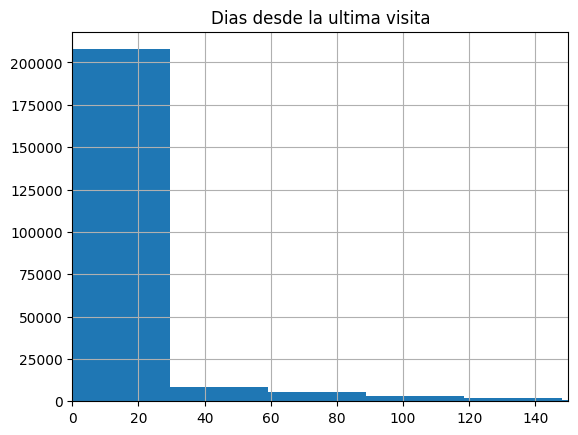

In [39]:
first_log = df_visits.groupby('Uid').agg({'Start Ts':'min'}).reset_index()
first_log.columns = ['Uid', 'first_visit']

first_log_total = pd.merge(df_visits, first_log, on = 'Uid')
first_log_total['days_since_last_visit'] = (first_log_total['Start Ts'] - first_log_total['first_visit']).dt.days

frecuency_log = first_log_total.groupby('Uid').agg({'days_since_last_visit':'mean'})

frecuency_log['days_since_last_visit'].hist(bins=10)
plt.title('Dias desde la ultima visita')
plt.xlim(0,150)
print(f"Los usuarios regresan a visitar la pagina en promedio cada {round(frecuency_log['days_since_last_visit'].mean())} dias")


# Analisis de las ventas

## ¿Cuándo empieza la gente a comprar?

## ¿Cuántos pedidos hacen durante un período de tiempo dado?

## ¿Cuál es el tamaño promedio de compra?

## ¿Cuánto dinero traen? (LTV)

# Marketing

## ¿Cuánto dinero se gastó?

## ¿Cuál fue el costo de adquisición de clientes de cada una de las fuentes?

## ¿Cuán rentables eran las inversiones? (ROMI)

## Consejos